<a href="https://colab.research.google.com/github/samirgadkari/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module2-polynomial-regression/Polynomial_Log_linear_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Linear Regression Practice

## Use a Linear Regression model to get the lowest RMSE possible on the following dataset:

[Dataset Folder](https://github.com/ryanleeallred/datasets/tree/master/Ames%20Housing%20Data)

[Raw CSV](https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv)

## You model must include (at least):
- A log-transformed y variable
- Two polynomial features
- One interaction feature
- 10 other engineered features

What is the lowest Root-Mean-Squared Error that you are able to obtain? Share your best RMSEs in Slack!

Notes:

There may be some data cleaning that you need to do on some features of this dataset. Linear Regression will only accept numeric values and will not accept

Note* There may not be a clear candidate for an interaction term in this dataset. Include one anyway, sometimes it's a good practice for predictive modeling feature engineering in general. 

In [1]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print(sns.__version__)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

0.9.0


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
print('Shape:', df.shape)
pd.set_option('display.max_columns', 100)
df.head(5)

Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

### Try plotting all features against log(SalePrice)

In [0]:
df['SalePrice'] = np.log(df['SalePrice'])

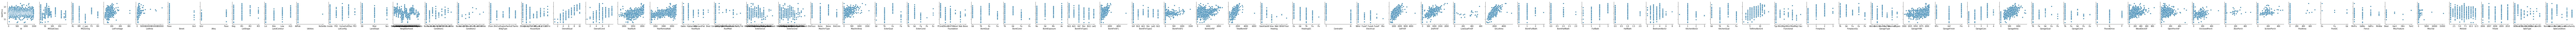

In [6]:
sns.pairplot(data = df, y_vars = 'SalePrice',
             x_vars = df.drop('SalePrice', axis = 1).columns);

## Try some correlations between features and output

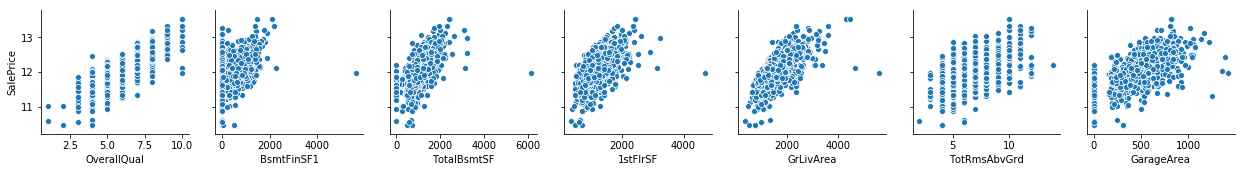

In [7]:
selected = df[['OverallQual', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 
                'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'SalePrice']].copy()
sns.pairplot(data = selected, y_vars = ['SalePrice'],
            x_vars = selected.columns.drop('SalePrice'));

### How do the correlations look

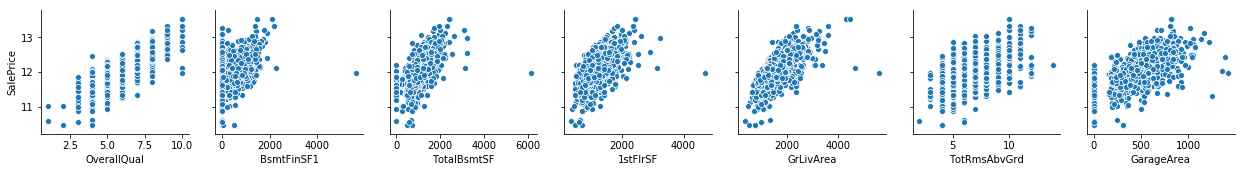

In [8]:
sns.pairplot(data = selected, y_vars = ['SalePrice'],
            x_vars = selected.columns.drop('SalePrice'));

## Clean your data as required

In [9]:
selected.isnull().sum()

OverallQual     0
BsmtFinSF1      0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
TotRmsAbvGrd    0
GarageArea      0
SalePrice       0
dtype: int64

### No cleaning required here.  Let's do the linear regression and find MSE and $R^2$

In [10]:
def find_mse_r2(df, y_col_name):
  X_train, X_test, y_train, y_test = \
    train_test_split(df.drop(y_col_name, axis = 1),
                      df[y_col_name],
                      test_size = 0.25)
  
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
  R2 = r2_score(y_test, y_pred)
  
  return (RMSE, R2)

RMSE, R2 = find_mse_r2(selected, 'SalePrice')
print('RMSE:', RMSE, 'R2:', R2)

RMSE: 0.1648683957478544 R2: 0.8080383476188235


## Let's do feature engineering

In [0]:
# These value give divide-by-zero error, so comment them out for now.
# selected['ln_MasVnrArea'] = np.log(df['MasVnrArea'] + 1)
# selected['ln_Fireplaces'] = np.log(df['Fireplaces'] + 0.5)
# selected['ln_WoodDeckSF'] = np.log(df['WoodDeckSF'] + 1)

selected['ln_TotRmsAbvGrd'] = np.log(df['TotRmsAbvGrd'])
selected['ln_GrLivArea'] = np.log(df['GrLivArea'])

selected['EnclosedPorch_squared'] = df['EnclosedPorch'] ** 2
selected['BsmtFinSF1_squared'] = df['BsmtFinSF1'] ** 2
selected['BsmtFinSF2_squared'] = df['BsmtFinSF2'] ** 2
selected['GarageYrBlt_squared'] = df['GarageYrBlt'] ** 2
selected['BsmtUnfSF_squared'] = df['BsmtUnfSF'] ** 2
selected['Age'] = df['YrSold'] - df['YearBuilt']

selected['LotScore'] = df['LotFrontage'] * df['LotArea']
selected['GarageScore'] = df['GarageArea'] * df['GarageCars']

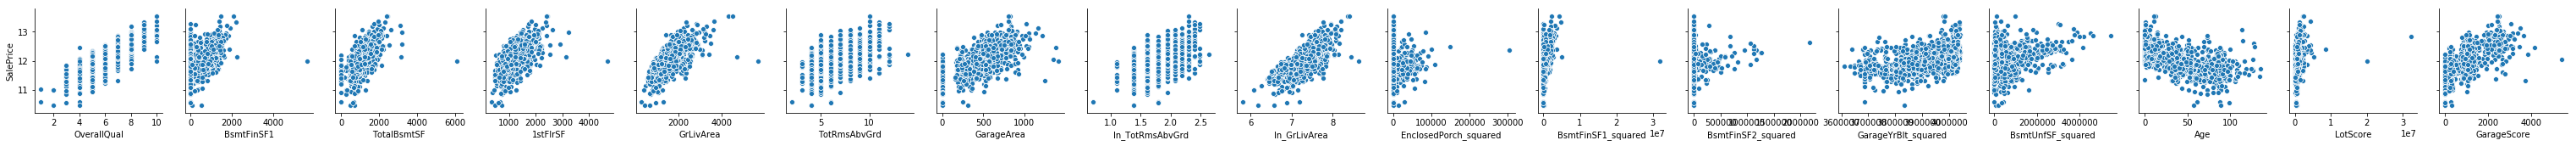

In [12]:
sns.pairplot(data = selected, y_vars = ['SalePrice'],
            x_vars = selected.drop(['SalePrice'], axis = 1).columns);

In [13]:
selected.dtypes

OverallQual                int64
BsmtFinSF1                 int64
TotalBsmtSF                int64
1stFlrSF                   int64
GrLivArea                  int64
TotRmsAbvGrd               int64
GarageArea                 int64
SalePrice                float64
ln_TotRmsAbvGrd          float64
ln_GrLivArea             float64
EnclosedPorch_squared      int64
BsmtFinSF1_squared         int64
BsmtFinSF2_squared         int64
GarageYrBlt_squared      float64
BsmtUnfSF_squared          int64
Age                        int64
LotScore                 float64
GarageScore                int64
dtype: object

In [14]:
print('selected.shape:', selected.shape)
print(selected.isnull().sum())

selected.shape: (1460, 18)
OverallQual                0
BsmtFinSF1                 0
TotalBsmtSF                0
1stFlrSF                   0
GrLivArea                  0
TotRmsAbvGrd               0
GarageArea                 0
SalePrice                  0
ln_TotRmsAbvGrd            0
ln_GrLivArea               0
EnclosedPorch_squared      0
BsmtFinSF1_squared         0
BsmtFinSF2_squared         0
GarageYrBlt_squared       81
BsmtUnfSF_squared          0
Age                        0
LotScore                 259
GarageScore                0
dtype: int64


In [15]:
print(np.isinf(selected).any())

OverallQual              False
BsmtFinSF1               False
TotalBsmtSF              False
1stFlrSF                 False
GrLivArea                False
TotRmsAbvGrd             False
GarageArea               False
SalePrice                False
ln_TotRmsAbvGrd          False
ln_GrLivArea             False
EnclosedPorch_squared    False
BsmtFinSF1_squared       False
BsmtFinSF2_squared       False
GarageYrBlt_squared      False
BsmtUnfSF_squared        False
Age                      False
LotScore                 False
GarageScore              False
dtype: bool


In [0]:
selected['GarageYrBlt_squared'] = selected['GarageYrBlt_squared'].fillna(method = 'ffill')
selected['LotScore'] = selected['LotScore'].fillna(method = 'ffill')

In [19]:
print('selected.shape:', selected.shape)
print(selected.isnull().sum())

selected.shape: (1460, 18)
OverallQual              0
BsmtFinSF1               0
TotalBsmtSF              0
1stFlrSF                 0
GrLivArea                0
TotRmsAbvGrd             0
GarageArea               0
SalePrice                0
ln_TotRmsAbvGrd          0
ln_GrLivArea             0
EnclosedPorch_squared    0
BsmtFinSF1_squared       0
BsmtFinSF2_squared       0
GarageYrBlt_squared      0
BsmtUnfSF_squared        0
Age                      0
LotScore                 0
GarageScore              0
dtype: int64


In [20]:
RMSE, R2 = find_mse_r2(selected, 'SalePrice')
print('RMSE:', RMSE, 'R2:', R2)

RMSE: 0.21774627918742984 R2: 0.6374916276358755


### We must have added some features that caused the RMSE to increase.  There is no guarantee that the RMSE will decrease as you add features.  I was only adding them because we had to have 10 engineered features.

# Stretch Goals

- Write a blog post explaining one of today's topics.
- Find a new regression dataset from the UCI machine learning repository and use it to test out your new modeling skillz.
 [ - UCI Machine Learning Repository - Regression Datasets](https://)
- Make a list for yourself of common feature engineering techniques. Browse Kaggle kernels to learn more methods.
- Start studying for tomorrow's topic: Gradient Descent
- Try and make the ultimate model with this dataset. clean as many features as possible, engineer the most sensible features as possible and see how accurate of a prediction you can make. 
- Learn about the "Dummy Variable Trap" and how it applies to linear regression modeling.
- Learning about using linear regression to model time series data